# Implementing Constant Proportion Portfolio Insurance (CPPI) and Drawdown Constraints

In [21]:
%load_ext autoreload
%autoreload 2

import edhec_risk_kit as erk
import numpy as np
import pandas as pd

#load the industry returns and the total market index returns we previously created
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of edhec_risk_kit failed: Traceback (most recent call last):
  File "c:\Users\shantala.mukherjee\OneDrive - Invartis Consulting\Python\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\shantala.mukherjee\OneDrive - Invartis Consulting\Python\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 

In [3]:
#Risky asset returns (we choose a few industries out of the 30)
risky_r = ind_return.loc["2000":][["Steel", "Fin", "Beer"]]

risky_r.shape

(291, 3)

In [4]:
#Safe asset returns (will be made up by us, should have the same shape as the dataframe of risky asset returns)
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.shape

(291, 3)

In [5]:
# insert values in the safe assets return dataframe
safe_r.loc[:] = 0.03/12 #constant of 3% per year
start = 1000 #starting value of the portfolio
floor = 0.8 #as a fraction of the starting value

1. Cushion = Asset Value - Floor Value

2. Compute an Allocation to Safe and Risky Assets --> m*risk budget

3. Recompute the Asset Value Based on the Returns

In [6]:
# to show different compute times for differently defined functions that do the same thing, we will try out the following examples

def compound1(r):
    return (1+r).prod()-1

def compound2(r):
    return np.expm1(np.log1p(r).sum())

In [7]:
compound1(risky_r)

Steel    1.993119
Fin      4.342660
Beer     6.456655
dtype: float64

In [8]:
compound2(risky_r)

Steel    1.993119
Fin      4.342660
Beer     6.456655
dtype: float64

Now we will use the timeit magic command to check how much time it takes to run each of these function

In [9]:
%timeit compound1(risky_r)

374 µs ± 34.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
%timeit compound2(risky_r)

292 µs ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Back to CPPI Exercise

In [11]:
# now we will implement our first for loop, in the most efficient way we can
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3 #we will set the multiplier at 3
account_history = pd.DataFrame().reindex_like(risky_r) # dataframe of portfolio account values
cushion_history = pd.DataFrame().reindex_like(risky_r) # dataframe of cushion values
risky_wt_history = pd.DataFrame().reindex_like(risky_r) # dataframe of allocation to risky assets

for step in range(n_steps): # iterating from 0 to n_steps-1
    cushion = (account_value - floor_value)/account_value
    risky_wt = m*cushion
    risky_wt = np.minimum(risky_wt, 1) #allocation to the risky asset is capped at 100%
    risky_wt = np.maximum(risky_wt, 0) #allocation to the risky asset is non-negative
    safe_wt = 1 - risky_wt # allocation to the  safe asset
    risky_alloc = account_value*risky_wt
    safe_alloc = account_value*safe_wt
    # update the account value for this time step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    # save the values so that the history is available and can be plotted
    cushion_history.iloc[step] = cushion
    risky_wt_history.iloc[step] = risky_wt
    account_history.iloc[step] = account_value



In [12]:
account_history.head()

,Steel,Fin,Beer
2000-01,986.480000,973.820000,987.260000
2000-02,1027.995112,929.114566,922.876330
2000-03,1052.315833,996.201219,924.778029
2000-04,1046.998674,975.500738,939.967067
2000-05,1011.899473,1002.843044,991.193484


In [14]:
risky_wealth = start*(1+risky_r).cumprod() # growth of wealth if invested purely in the risky asset

<Axes: >

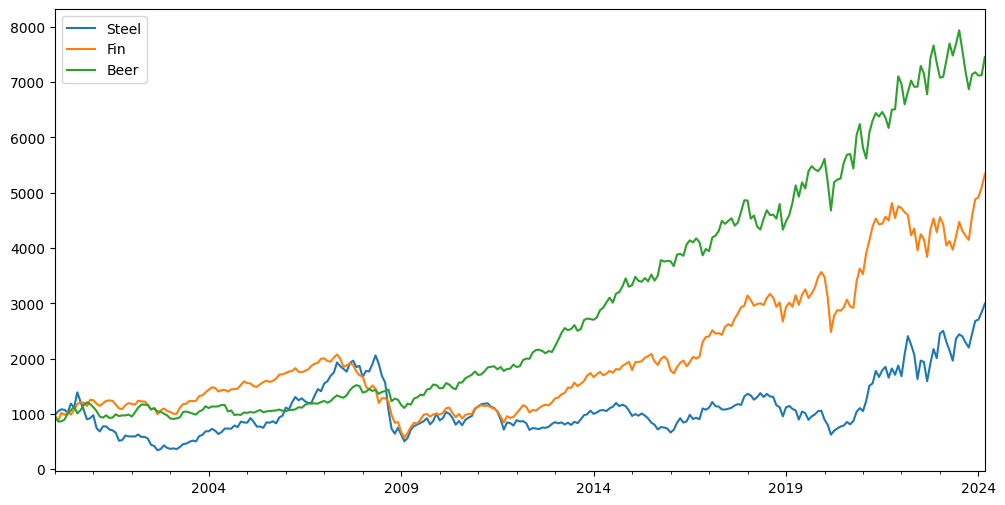

In [15]:
risky_wealth.plot(figsize=(12,6))

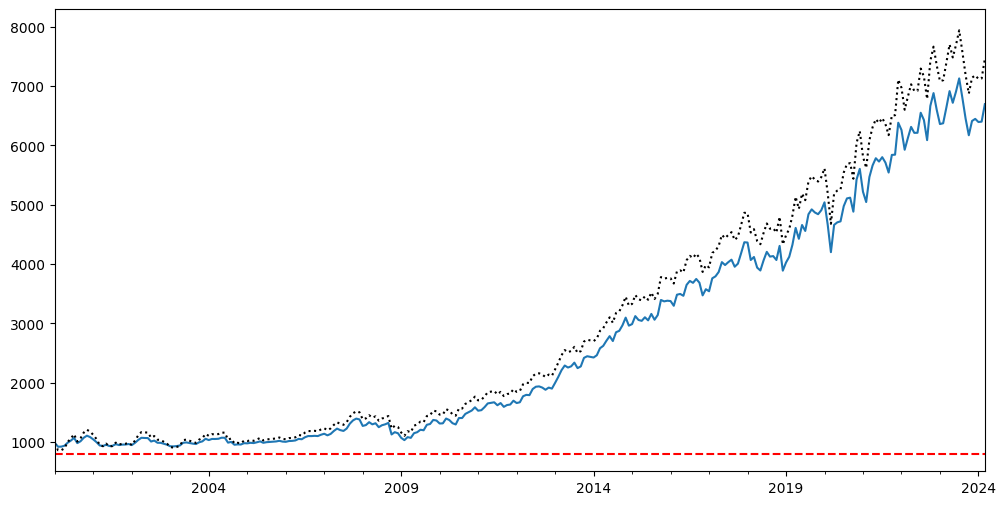

In [16]:
ax = account_history["Beer"].plot(figsize=(12,6)) #cppi portfolio value growth for Beer
risky_wealth["Beer"].plot(ax=ax,style="k:") #black and dotted line
ax.axhline(y=floor_value, color='r', linestyle="--")

<Axes: >

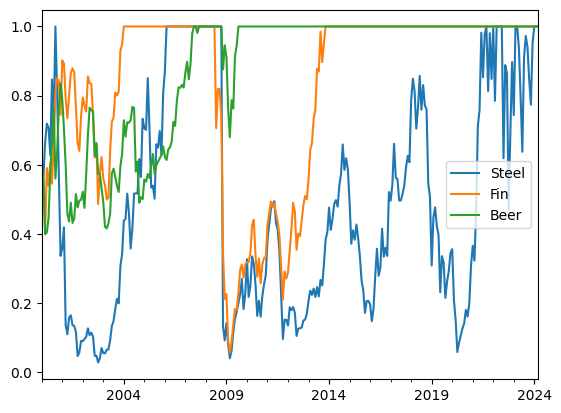

In [17]:
risky_wt_history.plot()

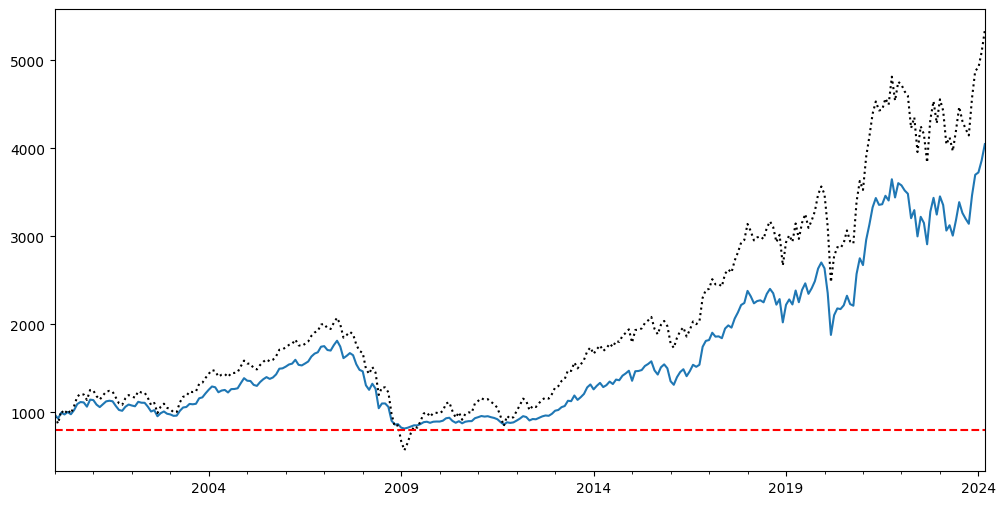

In [18]:
ind = "Fin"
ax = account_history[ind].plot(figsize=(12,6)) #cppi portfolio value growth for Beer
risky_wealth[ind].plot(ax=ax,style="k:") #black and dotted line
ax.axhline(y=floor_value, color='r', linestyle="--")

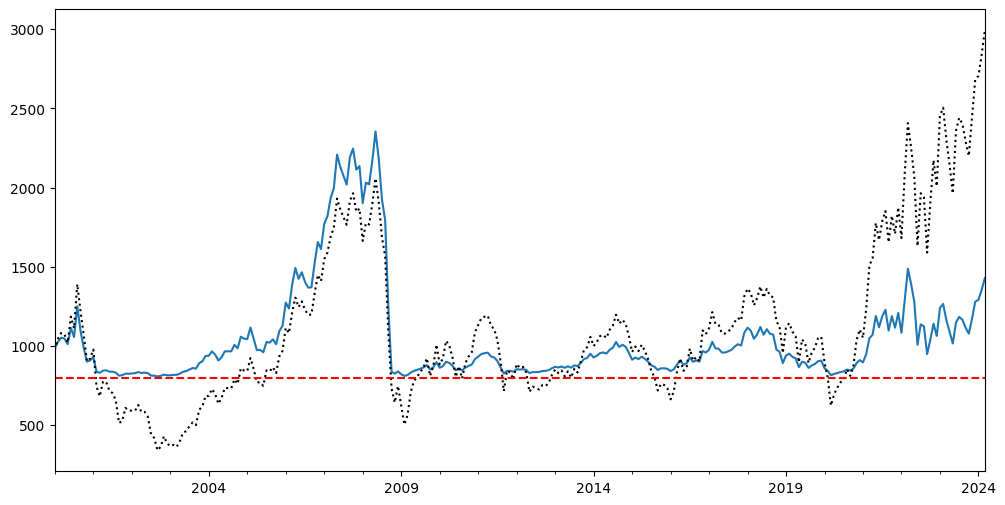

In [19]:
ind = "Steel"
ax = account_history[ind].plot(figsize=(12,6)) #cppi portfolio value growth for Beer
risky_wealth[ind].plot(ax=ax,style="k:") #black and dotted line
ax.axhline(y=floor_value, color='r', linestyle="--")

In [23]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.046246,0.333253,-0.158269,3.557228,0.152698,0.208260,0.047011,-0.755477
Fin,0.071546,0.200329,-0.501878,4.756598,0.093401,0.133993,0.201584,-0.726087
Beer,0.086379,0.143005,-0.333936,3.795200,0.063170,0.089547,0.383539,-0.271398


In [26]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr["Wealth"].pct_change().dropna()) #apply summary stats function on the returns obtained as percentage changes of the Wealth series in the CPPI backtest results

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.015438,0.196975,-1.002309,10.424468,0.096988,0.139665,-0.072223,-0.655518
Fin,0.060738,0.155145,-0.588990,5.838795,0.072231,0.104945,0.192628,-0.550283
Beer,0.082431,0.125533,-0.355194,4.136535,0.054962,0.076386,0.406363,-0.259442


<Axes: >

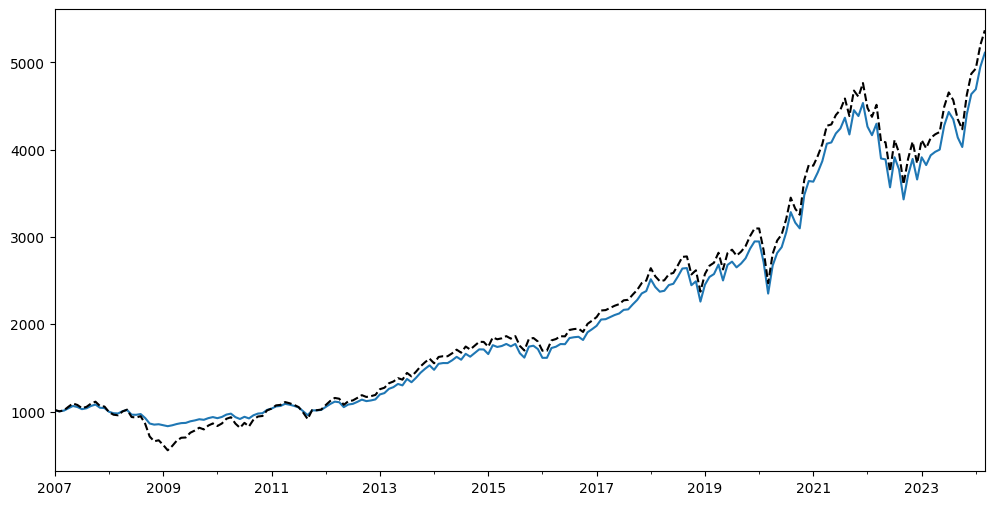

In [27]:
btr = erk.run_cppi(tmi_return.loc["2007":])
ax = btr["Wealth"].plot(figsize=(12,6), legend=False)
btr["Risky Wealth"].plot(ax=ax, style="k--", legend=False)

In [28]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.101683,0.162694,-0.52716,3.934318,0.073744,0.099567,0.428639,-0.50028


In [29]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.098927,0.133632,-0.285746,4.330216,0.056698,0.082094,0.501872,-0.2435


Next, we improve our run_cppi function by adding a drawdown constraint -- updated in erk module

## Running backtest with drawdown constraint

In [31]:
btr = erk.run_cppi(ind_return.loc["2007":][["Steel", "Fin", "Beer"]], drawdown=0.25)

<Axes: >

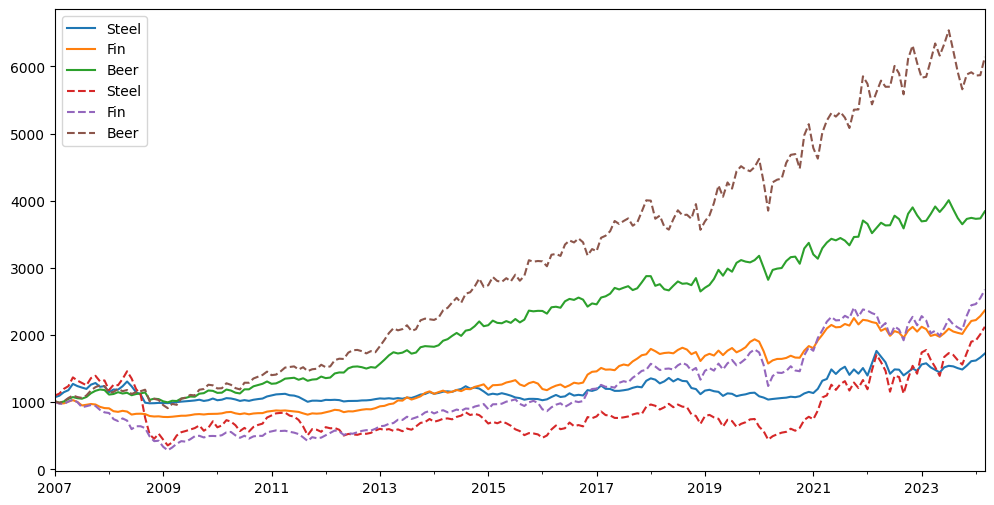

In [32]:
ax = btr["Wealth"].plot(figsize=(12,6))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [33]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.039114,0.337382,-0.159249,3.664764,0.154848,0.206145,0.025850,-0.755477
Fin,0.058762,0.216872,-0.610231,4.411401,0.104572,0.148127,0.128791,-0.726087
Beer,0.110461,0.137296,-0.349913,3.836616,0.058655,0.079155,0.570245,-0.271398


In [34]:
erk.summary_stats(btr["Wealth"].pct_change().dropna()) #check in the Max Drawdown column if the drawdowns are less than 0.25

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.027927,0.119769,0.161924,4.964732,0.050869,0.074267,-0.016989,-0.247928
Fin,0.051272,0.097598,-0.501426,4.022215,0.044950,0.061979,0.212012,-0.244045
Beer,0.080754,0.092249,-0.449402,3.697560,0.039769,0.053655,0.535380,-0.161222
